# Data Processing - Online Session

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
import matplotlib.image as mpimg
LOKY_MAX_CPU_COUNT = 4

## Read Dataframe

In [2]:
# Read csv
data = pd.read_csv('video1713189655.csv')
print("Shape: " + str(data.shape))

Shape: (18727, 23)


## Columns

### Remove unnecessary columns

In [3]:
# remove column 'ad_displayed' and 'pose_plus_gaze_yaw', 'pose_plus_gaze_pitch' 
data = data.drop(columns=['ad_displayed', 'pose_plus_gaze_yaw','pose_plus_gaze_pitch'])

### Column 'facial_expression'

In [5]:
# Rename 'emotion' column to 'facial_expression'
data = data.rename(columns={'emotion': 'facial_expression'})

# Rename the facial expressions
data['facial_expression'] = data['facial_expression'].replace({
    'sad' : 'tired',
    'anger' : 'frowning',
    'surprise' : 'admired',
    'happy' : 'smilling'
})

print(data['facial_expression'].value_counts())

#Remove 'unknown' values
data = data.drop(data.loc[data['facial_expression'] == 'unknown'].index)

facial_expression
neutral     12274
smilling     2625
frowning     1771
admired      1146
tired         841
unknown        70
Name: count, dtype: int64


### Column 'face_x1y1x2y2_coordinates'

In [6]:
# Calculate the center of the face (return a tuple (xx,yy))
def calculate_center_face(row):
    x1, y1, x2, y2 = row['face_bbox_x1'], row['face_bbox_y1'], row['face_bbox_x2'], row['face_bbox_y2']
    centro_x = (x1 + x2) / 2
    centro_y = (y1 + y2) / 2
    return pd.Series([centro_x, centro_y], index=['face_center_x', 'face_center_y'])

# Aplicar a função e criar as novas colunas
data[['face_center_x', 'face_center_y']] = data.apply(calculate_center_face, axis=1)

# Calcular a área da face (continua igual)
data['face_area'] = (data['face_bbox_x2'] - data['face_bbox_x1']) * (data['face_bbox_y2'] - data['face_bbox_y1'])

### Column 'time'

In [9]:
data['datetime'] = pd.to_datetime(data['datetime'])
data['datetime'].describe() 
start_video = pd.Timestamp('2024-12-12 17:49:54.000')
start_dataset = data['datetime'].min()
time_difference = start_video - start_dataset
data['datetime'] = data['datetime'] + time_difference

total_time = (data['datetime'].max() - data['datetime'].min()).total_seconds()
video_duration_sec = 17*60+14
scale = video_duration_sec/total_time
data['datetime'] = data['datetime'].min() + (data['datetime'] - data['datetime'].min()) * scale


print(data['datetime'].max() - data['datetime'].min())
print(data['datetime'].min())

0 days 00:17:14
2024-12-12 17:49:54


### Select the part when all people were in the call

In [12]:
# Divide de dataset in 2 parts:
# 1 - when were 4 people until 21:09
# 2 - when were 2 people

data['datetime'] = pd.to_datetime(data['datetime'])

time_limit_1 = data['datetime'].min() + pd.Timedelta(seconds=1*60+21)
time_limit_2 = data['datetime'].min() + pd.Timedelta(seconds=13*60+55)

data = data[(data['datetime'] <= time_limit_2) & (data['datetime'] >= time_limit_1)]

print(data['datetime'].describe())

count                            13709
mean     2024-12-12 17:56:56.876692736
min      2024-12-12 17:51:15.079373064
25%      2024-12-12 17:53:33.389115648
50%      2024-12-12 17:56:35.533417728
75%      2024-12-12 18:00:13.867871232
max      2024-12-12 18:03:48.737847307
Name: datetime, dtype: object


In [14]:
data.shape

(13709, 23)

## Modelos Clustering

In [15]:
kmeans = True
kprototypes = False

In [16]:
data.columns

Index(['datetime', 'source', 'face', 'face_bbox_x1', 'face_bbox_y1',
       'face_bbox_x2', 'face_bbox_y2', 'head_yaw', 'head_pitch', 'head_roll',
       'left_eye_state', 'right_eye_state', 'left_eye_state_confidence',
       'right_eye_state_confidence', 'gaze_yaw', 'gaze_pitch',
       'facial_expression', 'race', 'gender', 'age', 'face_center_x',
       'face_center_y', 'face_area'],
      dtype='object')

### K-Means

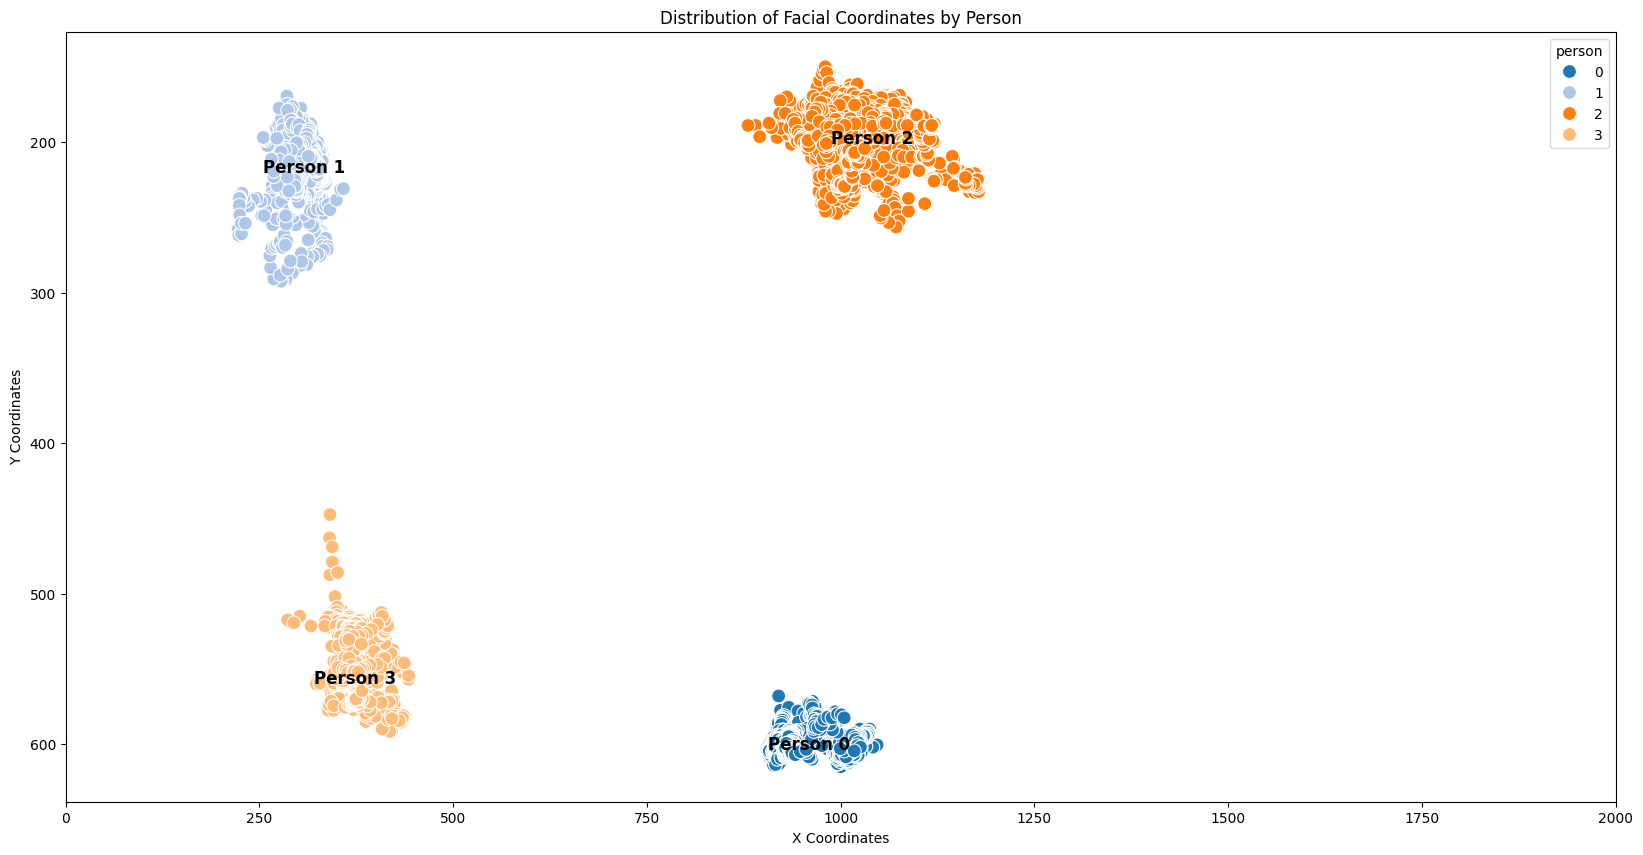

In [17]:
if kmeans:
    
    features = ['face_center_x', 'face_center_y']

    pipeline = Pipeline(steps=[ ('person', KMeans(n_clusters=4, random_state=42)) ])
    pipeline.fit(data[features])
    data['person'] = pipeline['person'].labels_

    plt.figure(figsize=(20, 10))
    sns.scatterplot(x='face_center_x', y='face_center_y', hue='person', data=data, palette='tab20', s=100)

    person_means = data.groupby('person')[['face_center_x', 'face_center_y']].mean().reset_index()
    for _, row in person_means.iterrows():
        plt.text(row['face_center_x'], row['face_center_y'], f"Person {int(row['person'])}", 
                 color='black', fontsize=12, weight='bold', ha='center', va='center')

    plt.title('Distribution of Facial Coordinates by Person')
    plt.xlabel('X Coordinates')
    plt.ylabel('Y Coordinates')
    plt.xlim(0,2000)
    plt.gca().invert_yaxis()
    plt.show()

#### Adjust borders ('source' == 1)

person
2    3468
1    3451
3    3446
0    3344
Name: count, dtype: int64


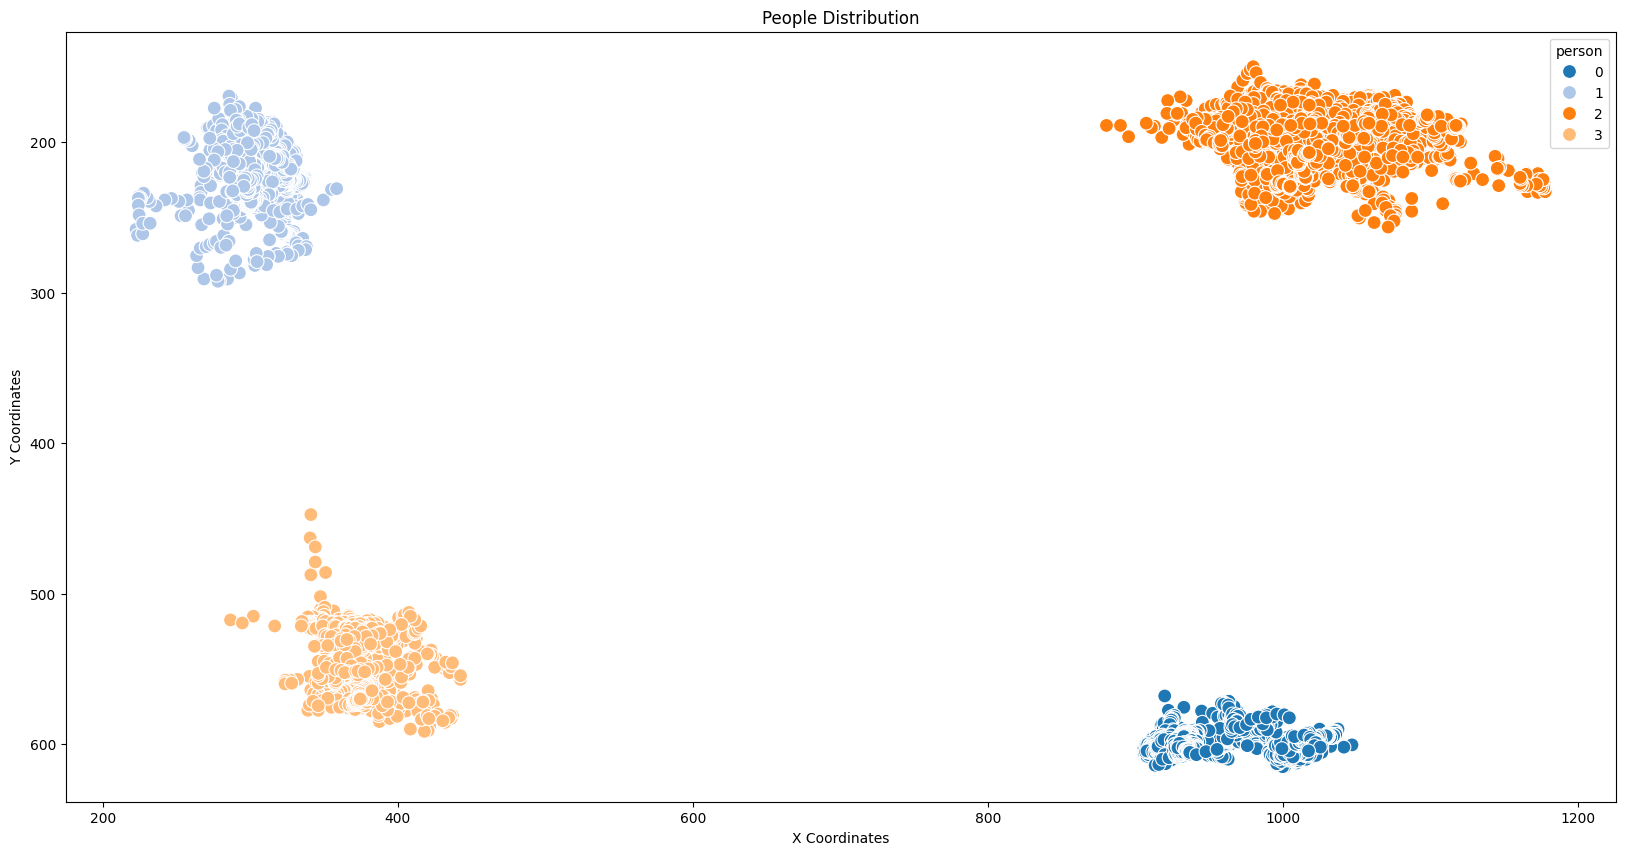

In [18]:
if kmeans: 
    # Group data by face and atributtes to that face the mode of the person in that face
    face_mode = data.groupby('face')['person'].agg(lambda x: x.mode().iloc[0]).to_dict()
    data['person'] = data['face'].map(face_mode)
    print(data['person'].value_counts())

    plt.figure(figsize=(20, 10))
    sns.scatterplot(x='face_center_x', y='face_center_y', hue='person', data=data, palette='tab20', s=100)
    plt.title('People Distribution')
    plt.xlabel('X Coordinates')
    plt.ylabel('Y Coordinates')
    plt.gca().invert_yaxis() 
    plt.show()

### K-Prototypes

#### 'source' == 1

In [307]:
def column_index(df, query_cols):    
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, query_cols, sorter=sidx)]

if kprototypes:
    
    features = ['face_x', 'face_y', 'face', 'gender']
    processed_df = data[features]
    
    # Find categorical columns
    cat_cols = processed_df.select_dtypes(include='object')
    categorical_indices = column_index(processed_df, cat_cols.columns)
    categorical = list(categorical_indices)

    kproto = KPrototypes(n_clusters=11, init='Cao', n_jobs=4, verbose=0, random_state=42)
    person = kproto.fit_predict(processed_df, categorical=categorical)
    data['person'] = person


    plt.figure(figsize=(20, 10))
    sns.scatterplot(x='face_x', y='face_y', hue='person', data=data, palette='tab20', s=100)

    person_means = data.groupby('person')[['face_x', 'face_y']].mean().reset_index()
    for _, row in person_means.iterrows():
        plt.text(row['face_x'], row['face_y'], f"Person {int(row['person'])}", 
                 color='black', fontsize=12, weight='bold', ha='center', va='center')
    plt.title('Distribution of Facial Coordinates by Person')
    plt.xlabel('X Coordinates')
    plt.ylabel('Y Coordinates')
    plt.gca().invert_yaxis()
    plt.show()

#### Adjust borders ('source' == 1)

In [308]:
if kprototypes:
    # Group data by face and atributtes to that face the mode of the person in that face
    face_mode = data.groupby('face')['person'].agg(lambda x: x.mode().iloc[0]).to_dict()
    data['person'] = data['face'].map(face_mode)
    print(data['person'].value_counts())

    plt.figure(figsize=(20, 10))
    sns.scatterplot(x='face_x', y='face_y', hue='person', data=data, palette='tab20', s=100)
    plt.title('People Distribution')
    plt.xlabel('X Coordinates')
    plt.ylabel('Y Coordinates')
    plt.gca().invert_yaxis() 
    plt.show()

#### 'source' == 0

In [309]:
if kprototypes:
    
    features = ['face_x', 'face_y', 'face', 'gender']
    processed_df = data[features]
    
    # Find categorical columns
    cat_cols = processed_df.select_dtypes(include='object')
    categorical_indices = column_index(processed_df, cat_cols.columns)
    categorical = list(categorical_indices)

    kproto = KPrototypes(n_clusters=11, init='Cao', n_jobs=4, verbose=0, random_state=42)
    person = kproto.fit_predict(processed_df, categorical=categorical)
    data['person'] = person


    plt.figure(figsize=(20, 10))
    sns.scatterplot(x='face_x', y='face_y', hue='person', data=data, palette='tab20', s=100)

    person_means = data.groupby('person')[['face_x', 'face_y']].mean().reset_index()
    for _, row in person_means.iterrows():
        plt.text(row['face_x'], row['face_y'], f"Person {int(row['person'])}", 
                 color='black', fontsize=12, weight='bold', ha='center', va='center')
    plt.title('Distribution of Facial Coordinates by Person')
    plt.xlabel('X Coordinates')
    plt.ylabel('Y Coordinates')
    plt.gca().invert_yaxis()
    plt.show()

#### Adjust borders ('source' == 0)

In [310]:
if kprototypes:
    # Group data by face and atributtes to that face the mode of the person in that face
    face_mode = data.groupby('face')['person'].agg(lambda x: x.mode().iloc[0]).to_dict()
    data['person'] = data['face'].map(face_mode)
    print(data['person'].value_counts())

    plt.figure(figsize=(20, 10))
    sns.scatterplot(x='face_x', y='face_y', hue='person', data=data, palette='tab20', s=100)
    plt.title('People Distribution')
    plt.xlabel('X Coordinates')
    plt.ylabel('Y Coordinates')
    plt.gca().invert_yaxis() 
    plt.show()

## Results

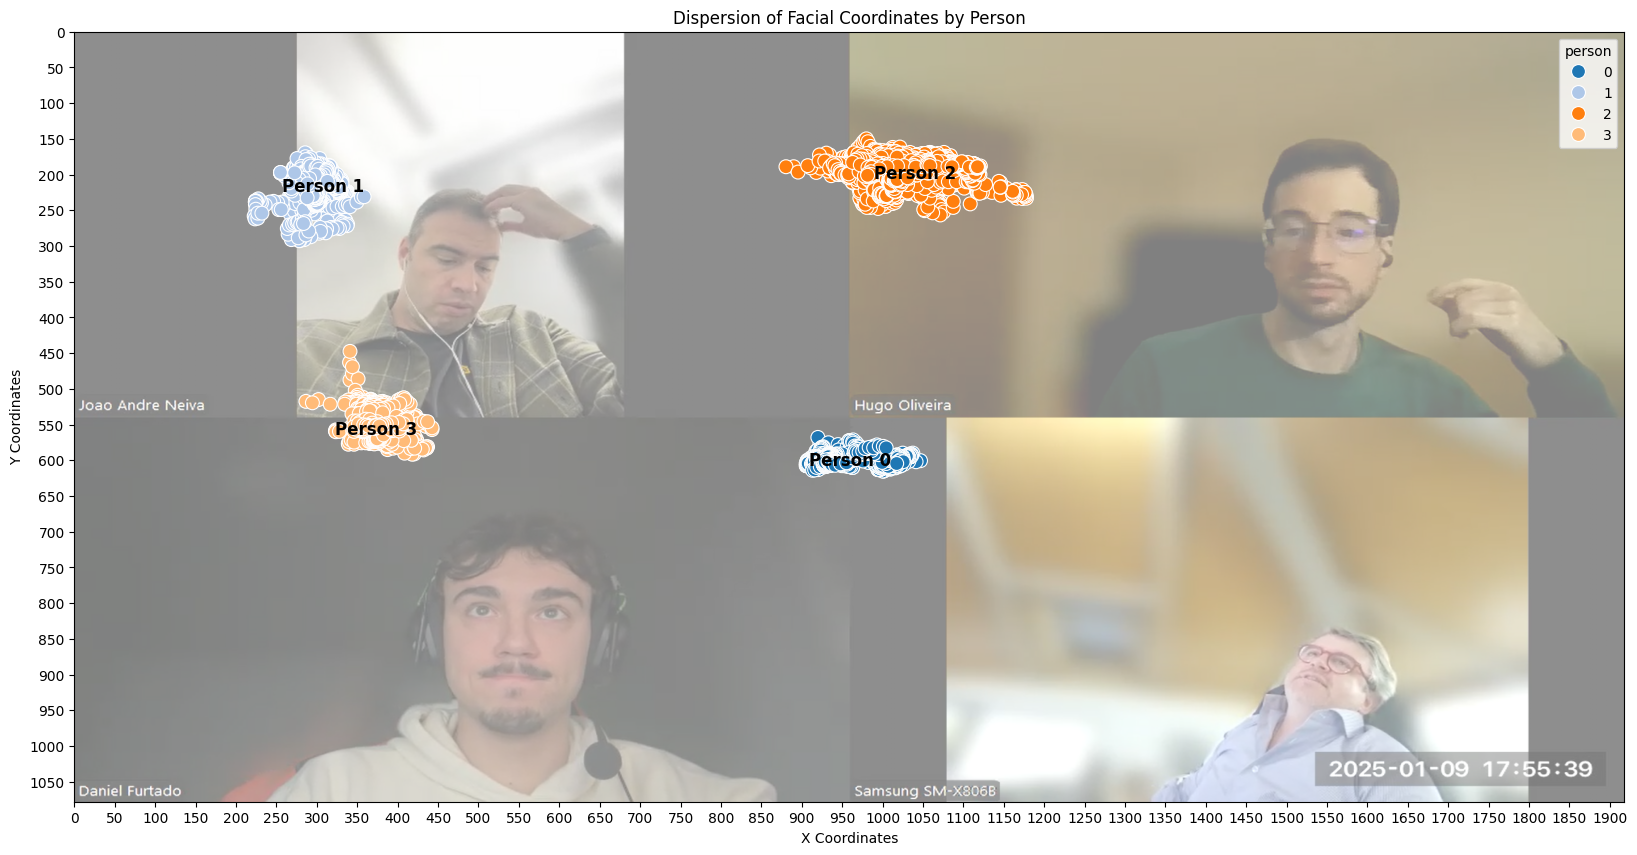

In [32]:
background_image = mpimg.imread('1.png') 
img_height, img_width = background_image.shape[:2]

plt.figure(figsize=(20, 10))
plt.imshow(background_image, extent=[0, img_width, 0, img_height], aspect='auto', alpha=0.5)
sns.scatterplot(x='face_center_x', y='face_center_y', hue='person', data=data, palette='tab20', s=100)
person_means = data.groupby('person')[['face_center_x', 'face_center_y']].mean().reset_index()
for _, row in person_means.iterrows():
    plt.text(row['face_center_x'], row['face_center_y'], f"Person {int(row['person'])}", color='black', fontsize=12, weight='bold', ha='center', va='center')
    
plt.xlim(0, img_width)
plt.ylim(0, img_height)
plt.xticks(np.arange(0, img_width+1, 50))
plt.yticks(np.arange(0, img_height+1, 50)) 
plt.title('Dispersion of Facial Coordinates by Person')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.gca().invert_yaxis()
plt.show()

## Temporal Line for Each Person

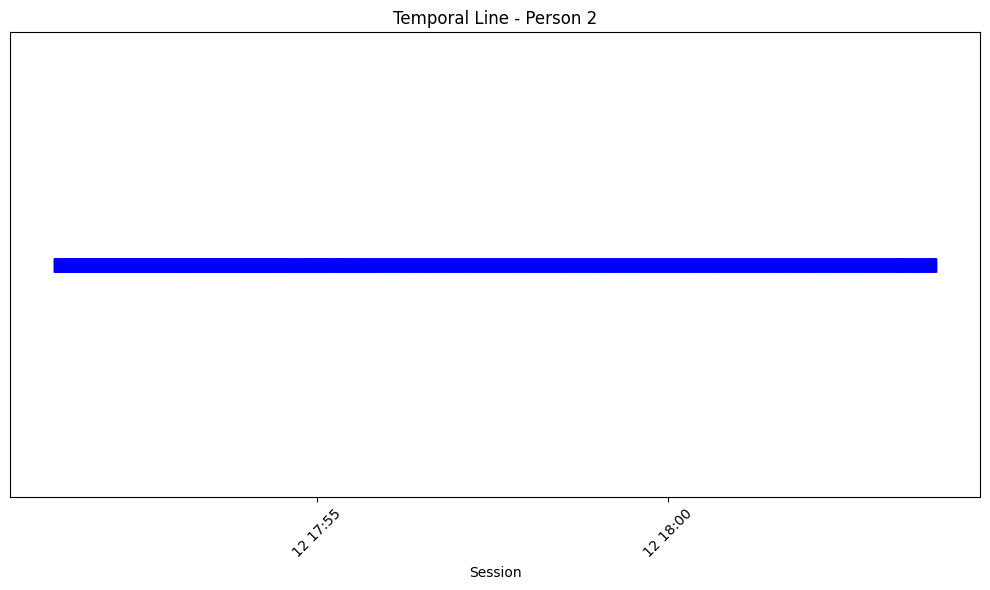

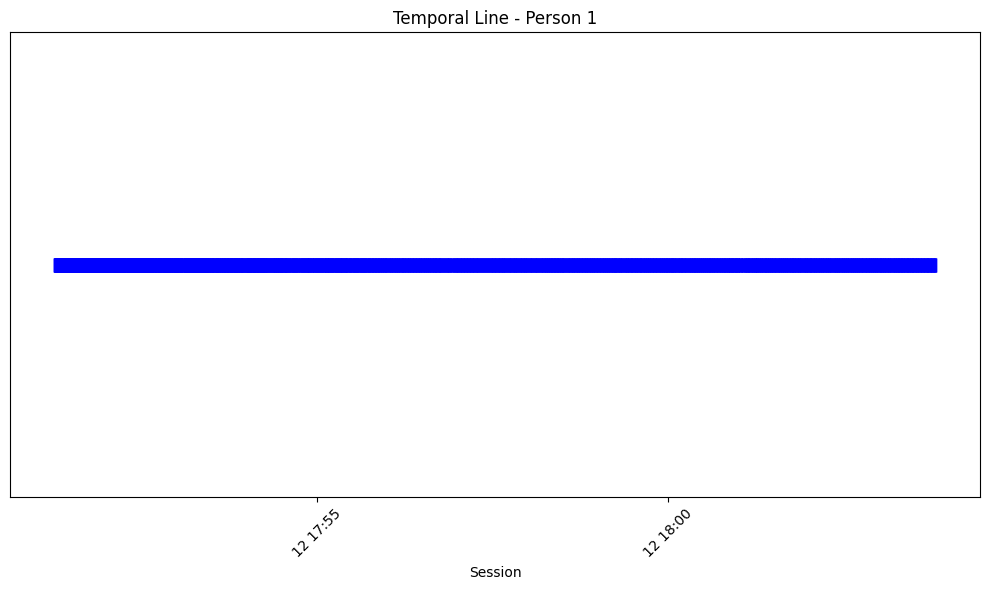

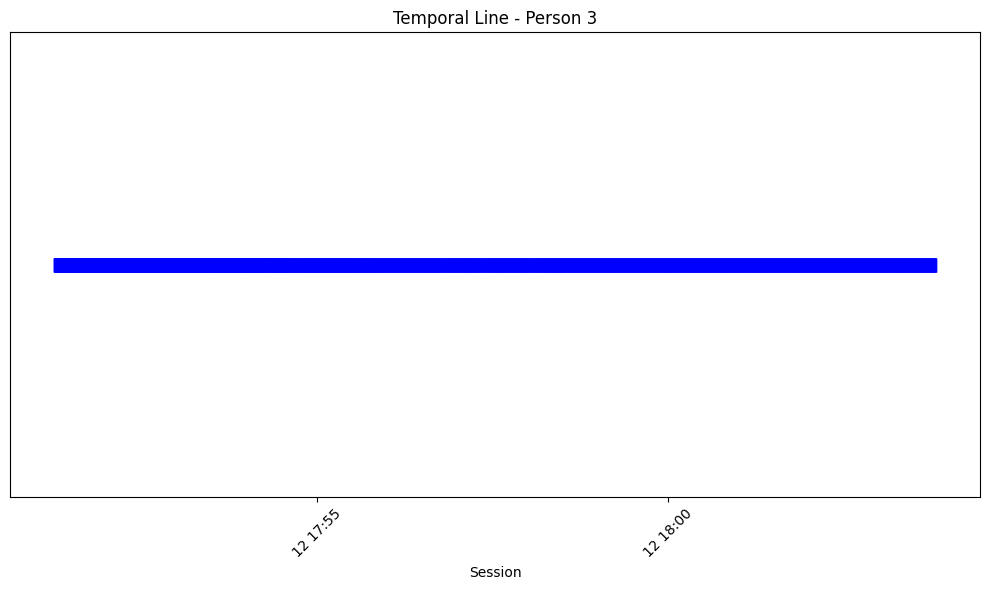

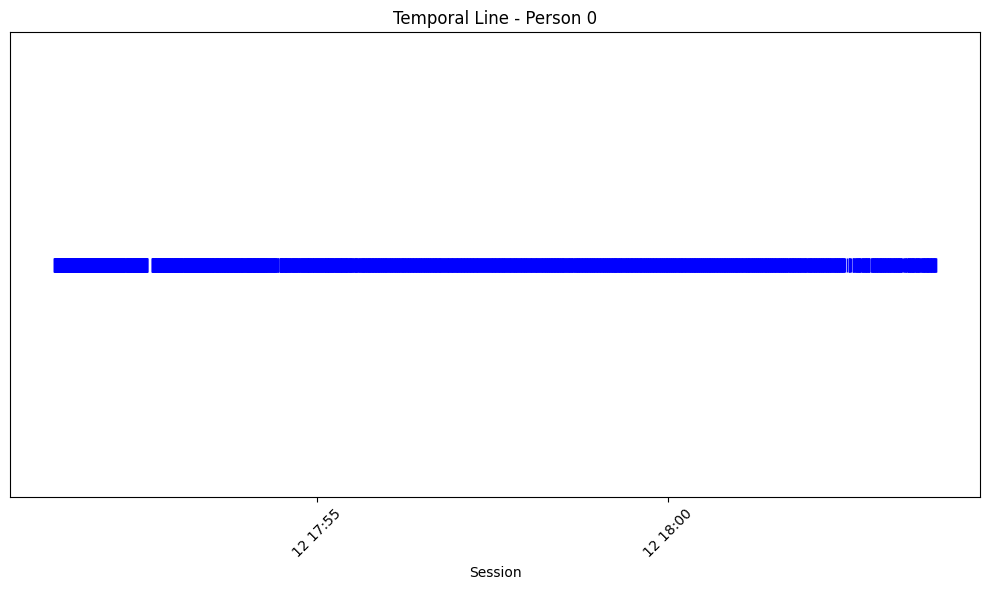

In [33]:
person = data['person'].unique()

for i in person:
    data_person_i = data[data['person'] == i]
    
    plt.figure(figsize=(10, 6))
    plt.plot(data_person_i['datetime'], [1] * len(data_person_i), '|', color='blue', markersize=10)
    plt.title(f'Temporal Line - Person {i}')
    plt.xlabel('Session')
    plt.yticks([]) 
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## Write Dataframe

In [34]:
data.to_csv('online_pre_processing.csv', index=False)